In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import date, datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.simplefilter('ignore', category=Warning, lineno=0, append=False)

# Pre-processing the data

## Import the data

Here we are importing the data from the CSV file and displaying the first few rows

In [4]:
# import data
raw_df = pd.read_csv('..\data\\Online_Retail.csv')
raw_df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Checking the data structure

Checking the data structure gives us a greater understanding of the data being analised. It indicated the different data types used. There is also an indication of missing values, this will allow us to manage the missing values when doing our analysis.

Checking the data structure also allows us to see how many columns are present as well as how many entires. This gives us a foundational understanding of the data, helping to determine suitability for analysis tasks and guiding us towards the neccessary cleaning and pre-processing steps.

In [5]:
# Understand data structure
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


## Checking for missing values

The presence of missing values can siginificantly impact your analysis. Knowing the number of missing values of each column can help to make the right decisions of how to manage the columns.

In this case we can see that these are a lot of missing CustomerIDs and some missing Descriptions.

In [6]:
raw_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Data Cleaning

1. Irrelavant columns are dropped. These columns are not relevant to our analysis. The whole columns for both "Country" and "Description" are removed.

2. In the quantity column, rows with less than or equal to 0 are removed.

3. Rows with a missing `CustomerID` are removed.

4. Resetting the index, after dropping rows, ensures that the index will be continuous.

In [7]:
#Data Cleaning
# Drop 'Country' and 'InvoiceNo' columns
processed_df = raw_df.drop(['Country','Description'], axis=1)

# Remove rows with quantity less than or equal to zero
processed_df = processed_df[processed_df['Quantity'] >= 0]

# Remove rows with missing CustomerID
processed_df = processed_df.dropna(subset=['CustomerID'])

# Reset the index after removing rows
processed_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the processed DataFrame
print(processed_df.head())

  InvoiceNo StockCode  Quantity     InvoiceDate  UnitPrice  CustomerID
0    536365    85123A         6  12/1/2010 8:26       2.55     17850.0
1    536365     71053         6  12/1/2010 8:26       3.39     17850.0
2    536365    84406B         8  12/1/2010 8:26       2.75     17850.0
3    536365    84029G         6  12/1/2010 8:26       3.39     17850.0
4    536365    84029E         6  12/1/2010 8:26       3.39     17850.0


## Data Processing

By changing the Quantity data type to integer, will allow us to treat the quantities as whole numbers, which will be used for numberical calculations.
`CustomerID` are unique identitfiers for each customer. Changing these values to string, enusres that the values will not be used for any calculations, keeping the values the same.

In [8]:
#Data Processing
processed_df['Quantity'] = processed_df['Quantity'].astype(int)
processed_df['CustomerID'] = processed_df['CustomerID'].astype(str)
print(processed_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Quantity     397924 non-null  int32  
 3   InvoiceDate  397924 non-null  object 
 4   UnitPrice    397924 non-null  float64
 5   CustomerID   397924 non-null  object 
dtypes: float64(1), int32(1), object(4)
memory usage: 16.7+ MB
None


## Feature engineering and Data preperation for RFM analysis
### Monetary values
1. Creating an `"Amount"` column. This new column will calculate the full amount spent by each customer on their order. The column is created by mulitplying the quantity by the unit price.

2. The data is grouped by CustomerID. Using the sum() method on the amount column, returns the total amount spent by each customer. This provides a measure of the total monetary value of a customer's transactions.

3. Grouping creates a hierarchical index. By using the reset_index() method we convert the "CustomerID" group back into a regular column. The columns are renamed "CustomerID" and "Amount" for clarity.

In [9]:
processed_df['Amount'] = processed_df['Quantity']*processed_df['UnitPrice']
rfm_ds_n = processed_df.groupby('CustomerID')['Amount'].sum()
rfm_ds_n.reset_index()
rfm_ds_n.columns = ['CustomerID', 'Amount']
print(rfm_ds_n)

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
             ...   
18280.0      180.60
18281.0       80.82
18282.0      178.05
18283.0     2094.88
18287.0     1837.28
Name: Amount, Length: 4339, dtype: float64


### Frequency values

1. Data is grouped by `"CustomerID"`. We count the "InvoiceNo" column to determine the number of invoices per customer. This count is used to represent the frequency in RFM.
2. Similarly as in the previous block, we reset_index() is used to convert "CustomerID" back into a regular column. Column is renamed "Frequency" for clarity.

In [10]:
rfm_ds_f = processed_df.groupby('CustomerID')['InvoiceNo'].count()
rfm_ds_f = rfm_ds_f.reset_index()
rfm_ds_f.columns = ['CustomerID','Frequency']
print(rfm_ds_f)

     CustomerID  Frequency
0       12346.0          1
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4334    18280.0         10
4335    18281.0          7
4336    18282.0         12
4337    18283.0        756
4338    18287.0         70

[4339 rows x 2 columns]


### Recency values

1. Invoice is converted to DateTime. This allows for calculations to determine recency.
2. Find the most recent invoice date using the max() function.
3. Calculate the difference for each customer. This indicates the time that has passed between a customer's last purchace.
4. Data is grouped by `"CustomerID"`. The min() method is used to find the minimum difference, to determine the most recent purchase by each customer.
5. We again make use of the reset_index() method to convert "CustomerID" to a regular column.
6. Convert the difference to days.

In [14]:
processed_df['InvoiceDate'] = pd.to_datetime(processed_df['InvoiceDate'],format='%m/%d/%Y %H:%M')
max_date = max(processed_df['InvoiceDate'])
processed_df['Diff'] = max_date - processed_df['InvoiceDate']
rfm_ds_p = processed_df.groupby('CustomerID')['Diff'].min()
rfm_ds_p = rfm_ds_p.reset_index()
rfm_ds_p.columns = ['CustomerID', 'Diff']
rfm_ds_p['Diff'] = rfm_ds_p['Diff'].dt.days
print(rfm_ds_p)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4334    18280.0   277
4335    18281.0   180
4336    18282.0     7
4337    18283.0     3
4338    18287.0    42

[4339 rows x 2 columns]


### Creating the final RFM dataframe

1. `rfm_ds_n` (Data frame containing total "Amount") is being merged with rfm_ds_f(Data frame containging "Frequency"). Making use of the on='CustomerID' argument, ensures the merge will be performed on matching 'CustomerID' values.
2. The final data frame is then merged with the data frame containing the Recency values (frm_ds_p). Again, the merge is based on the CustomerID .
3. Columns are renamed for clarity.
4. The results are displayed.

In [15]:
rfm_ds_final = pd.merge(rfm_ds_n, rfm_ds_f, on='CustomerID',how='inner')
rfm_ds_final = pd.merge(rfm_ds_final, rfm_ds_p, on='CustomerID', how='inner')
rfm_ds_final.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_ds_final)

     CustomerID    Amount  Frequency  Recency
0       12346.0  77183.60          1      325
1       12347.0   4310.00        182        1
2       12348.0   1797.24         31       74
3       12349.0   1757.55         73       18
4       12350.0    334.40         17      309
...         ...       ...        ...      ...
4334    18280.0    180.60         10      277
4335    18281.0     80.82          7      180
4336    18282.0    178.05         12        7
4337    18283.0   2094.88        756        3
4338    18287.0   1837.28         70       42

[4339 rows x 4 columns]


### Outlier handling
Removing the outliers in the dataset.
By removing the outliers from the data, we create a less extreme dataset, which might influence analysis.

In [16]:
#Outliers
Q1 = rfm_ds_final.Amount.quantile(0.25)
Q3 = rfm_ds_final.Amount.quantile(0.75)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Amount > Q1 - 1.5*IQR) & (rfm_ds_final.Amount < Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Recency.quantile(0.25)
Q3 = rfm_ds_final.Recency.quantile(0.75)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Recency > Q1 - 1.5*IQR) & (rfm_ds_final.Recency < Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Frequency.quantile(0.25)
Q3 = rfm_ds_final.Frequency.quantile(0.75)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Frequency > Q1 - 1.5*IQR) & (rfm_ds_final.Frequency < Q3 + 1.5*IQR)]

Checking the shape of the DataFrame. These two integer values will determine the number of rows and columns in the DataDrame. Checking the shape of the data, indicates how many points remain after removing the outliers. This data is used to determine if there is suffuient data to continue with the analysis.

In [17]:
print(rfm_ds_final.shape)

(3582, 4)


### Scaling

1. A new DataFrame "X" is created. Only numeric columns are selected.
2. The `MinMaxScaler()` is normally used for nomalisation of data, where the values are transformed to a range between 0 and 1.
3. The `fit_transform()` method is applied to the scaler. The features X is taken as input. The scaler is first "fitted" to the data, by determining the min and max values in each column, then it transforms the data by scaling each value to the 0-1 range. The result is stored in rfm_ds_scaled.

In [18]:
#scaling
X = rfm_ds_final[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
rfm_ds_scaled = scaler.fit_transform(X)

4. A new pandas DataFrame is created from rfs_ds_scaled.
5. Column names are set, since the scaling process does not preserve the original names.
6. The first few rows are displayed.

In [19]:
rfm_ds_scaled = pd.DataFrame(rfm_ds_scaled)
rfm_ds_scaled.columns = ['Amount', 'Frequency','Recency']
rfm_ds_scaled.head()

,Amount,Frequency,Recency
0,0.487869,0.169492,0.205556
1,0.477095,0.406780,0.050000
2,0.090774,0.090395,0.858333
3,0.680276,0.474576,0.097222
4,0.024159,0.016949,0.563889


### Model Creation

K-means clustering is used for customer segmentation. In this code block the k-means model is being created. The model is created using the sklearn.cluster library. After the model is initialised, the model is being fitted to the data.

In [20]:
#model creation
kmeans = KMeans(n_clusters= 3,max_iter= 50)
kmeans.fit(rfm_ds_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[2 1 0 ... 0 2 1]


### Determining the number of clusters (Elbow Method)

1. Using a for loop to iterate through a range of cluster numbers. For each number of clusters, a k-means model is created, and fitted on the scaled data.
2. For each iteration, the within-cluster sum of squares (wss) are calculated. This measures the total squared distance of data points within each cluster.
3. Plotting the data gives us a visual representation of the wss values for each number of clusters.

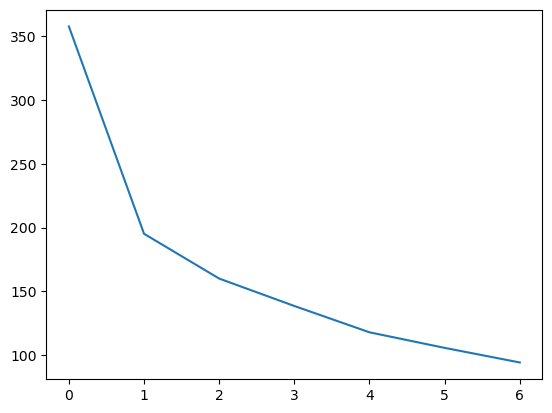

In [21]:
#wss
wss =[]
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters= num_clusters, max_iter= 50)
    kmeans.fit(rfm_ds_scaled)
    wss.append(kmeans.inertia_)

plt.plot(wss)

### Silhouette Score
1. Using a for loop to iterate through a list containing numbers of clusters.
2. For each number of clusters, the k-means model is fitted to the scaled data.
3. The cluster assignments for every data point are stored in labels_attribute of the fitted model.
4. sklearn.metrics is used to take the scaled data and the cluster labels as input. 
The function then calculates a silhouette score, this tells us how good the data is clustered within their assigned groups.
5. The results are printed for evaluation.

Silhouette scores lies between -1 and 1. Scores closer to 1 indicate better cluster seperation. Calculating the silhouette score, allows us to identify the configuration that maximises the average silhouette score, indicating optimal cluster seperation.

Compared to the elbow method, silhouette score provides a more quantitative measure of cluster quality.

In [22]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters= num_clusters, max_iter= 50)
    kmeans.fit(rfm_ds_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_ds_scaled, cluster_labels)
    print('For n_clusters{0}, the silhouette score is {1}'.format(num_clusters, silhouette_avg))

For n_clusters2, the silhouette score is 0.3931351113848015
For n_clusters3, the silhouette score is 0.45909556257124096
For n_clusters4, the silhouette score is 0.41184095469610466
For n_clusters5, the silhouette score is 0.35808470955460053
For n_clusters6, the silhouette score is 0.36285282254993245
For n_clusters7, the silhouette score is 0.3688089478124775
For n_clusters8, the silhouette score is 0.3432674102971437


### Revisiting the Data

This section revisits the data after outlier handling and scaling. We can use `X.head()` to view the first few rows of the DataFrame to get a glimpse of the processed data.

In [23]:
X = rfm_ds_final
X.head()

,CustomerID,Amount,Frequency,Recency
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
5,12352.0,2506.04,85,35
6,12353.0,89.00,4,203


### Final RFM Segmentation model

1. Creating a pipeline to streamline data processing by chaining together couple of steps:
- Firstly, `StandardScaler()` is used to ensure "Amount", "Frequency" and "Recency" is normalised before feeding them to the K-means clustering algorithm.
- Then, `KMeans(n_clusters=3, random_state=42)` defines that the K-Means model has 3 clusters and sets a random seed for reproducibility.
2. Fitting model and predicting labels.
- fit: the model is fitted on the data in X.
- predict: The model predicts cluster labels for the data points X.
3. Predicted labels are printed.

In [24]:
# final_model labels
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=3, random_state=42)
)
# Predict class labels
labels = final_model.fit_predict(X)
print(labels[:10])

[2 1 0 1 0 0 0 1 2 1]


Adding a new column called `"labels"` within our DataFrame X.

In [25]:
X['labels'] = final_model.named_steps["kmeans"].labels_
print(labels[:10])

[2 1 0 1 0 0 0 1 2 1]


### Visualising the RFM segmentation results

The results are visualised using a scatter plot. The points are colour coded to allow us to visualise how customers are distributed based on their Recency and Amount, after segmentation.

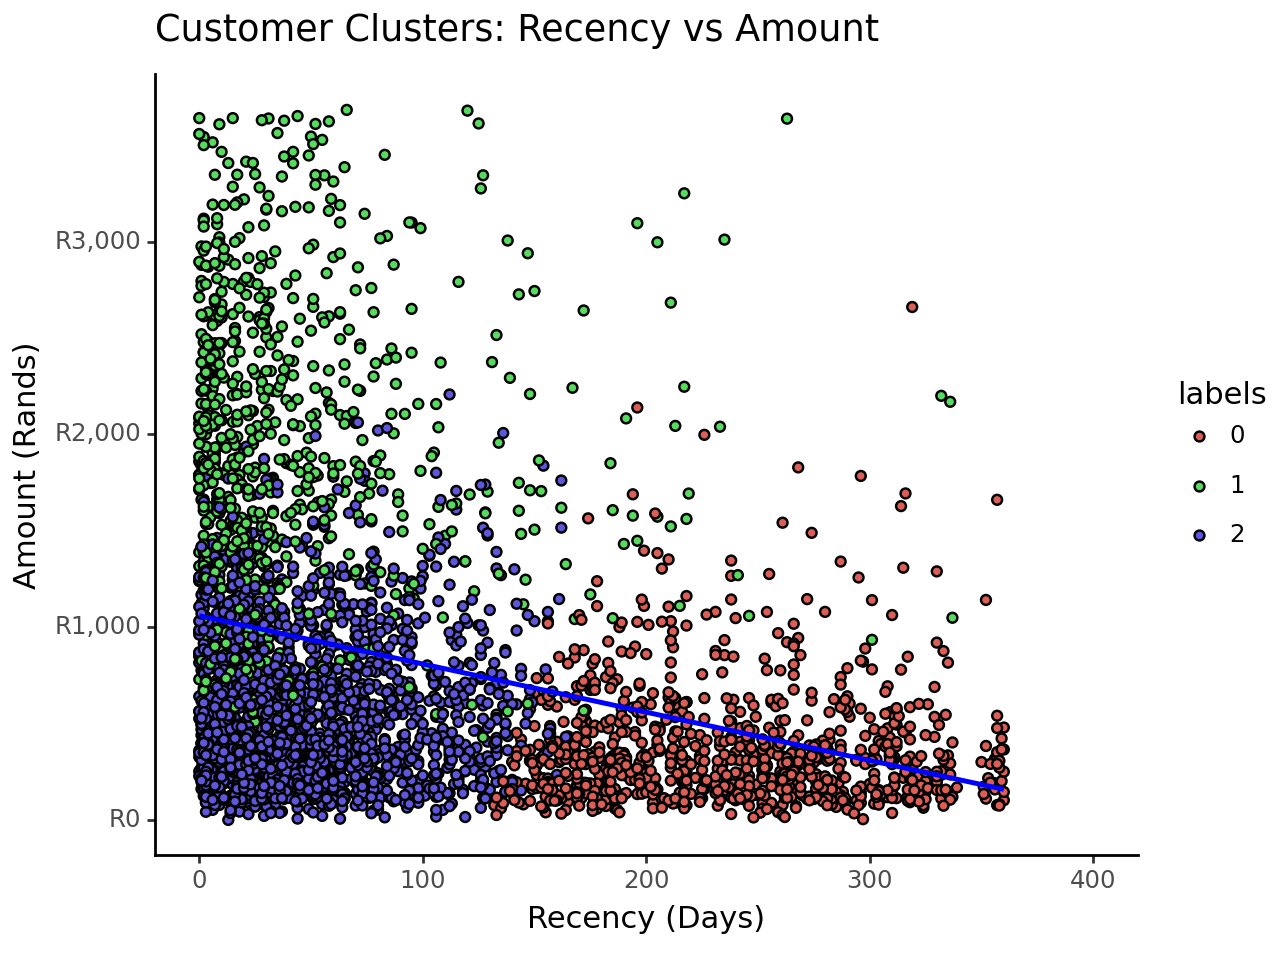

In [26]:
import plotnine as pn
from plotnine import *

# Create a plot area
p = (
    ggplot(X, aes(x='Recency', y='Amount')) +
    # Add points into the plot area
    geom_point(aes(fill=X['labels'].astype(str))) +
    # Add a blue smooth line
    geom_smooth(color="blue", se=False) +
    # Format x-axis scale to display 'Frequency'
    scale_x_continuous(
        name='Recency (Days)',
        labels=lambda x: [f'{x:,.0f}' for x in x],
        limits=(0, 400)  # Adjust x-axis limits to zoom in
    ) +
    # Format y-axis scale to display 'Rands'
    scale_y_continuous(
        name='Amount (Rands)',
        labels=lambda y: [f'R{y:,.0f}' for y in y]
    ) +
    # Add title to the plot
    labs(title="Customer Clusters: Recency vs Amount") +
    # Add plot theme
    theme_classic()
)

# Show the plot
print(p)


The results are visualised using a scatter plot. Here the scatter plot visualises how customers are grouped based on their Frequency and Amount, after segmentation.

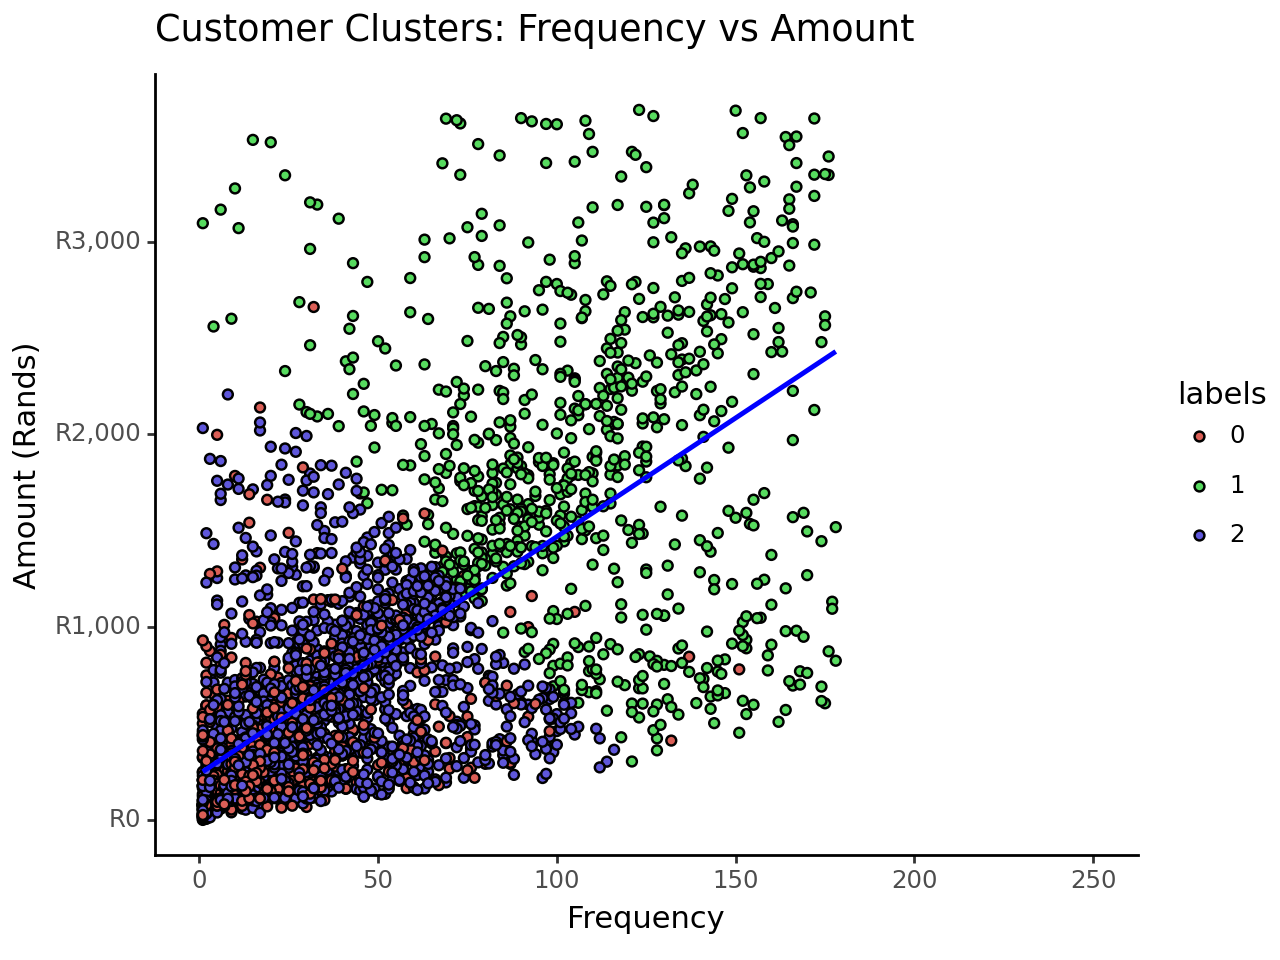

In [27]:
import plotnine as pn
from plotnine import *

# Create a plot area
p = (
    ggplot(X, aes(x='Frequency', y='Amount')) +
    # Add points into the plot area
    geom_point(aes(fill=X['labels'].astype(str))) +
    # Add a blue smooth line
    geom_smooth(color="blue", se=False) +
    # Format x-axis scale to display 'Frequency'
    scale_x_continuous(
        name='Frequency',
        labels=lambda x: [f'{x:,.0f}' for x in x],
        limits=(0, 250)  # Adjust x-axis limits to zoom in
    ) +
    # Format y-axis scale to display 'Rands'
    scale_y_continuous(
        name='Amount (Rands)',
        labels=lambda y: [f'R{y:,.0f}' for y in y]
    ) +
    # Add title to the plot
    labs(title="Customer Clusters: Frequency vs Amount") +
    # Add plot theme
    theme_classic()
)

# Show the plot
print(p)